##### Данное исследование разделим на несколько частей.

##### I. Изучение общей информации:
* [1. Загрузка данных и используемых библиотек ](#1-section)
* [2. Изучение файлов с данными, получение общей информации](#2-section)

##### II. Обучение и проверка модели:
* [1. Подготовка к обучению моделей](#3-section)
* [2. Константные модели](#4-section)
* [3. Линейная регрессия](#5-section)
* [4. Решающее дерево](#6-section)
* [5. Случайный лес](#7-section)
* [6. Градиентный бустинг](#8-section)

##### III. Расчёт прибыли:
* [1. Подготовка к расчёту прибыли](#9-section)
* [2. Расчёт прибыли](#10-section)

##### IV. Распределение прибыли и риски:
* [1. Bootstrap](#11-section)

##### [V. Общий вывод](#12-section)

## I. Изучение общей информации

<a id='1-section'></a>
### 1. Загрузка данных и используемых библиотек

In [4]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import seaborn as sns
from scipy.stats import norm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

In [5]:
# создадим функцию для загрузки датасета
def load_data(csv):
    try:
        data = pd.read_csv(csv)
        return data
    except:
        print('Ошибка при чтении файла!')

In [6]:
# загрузим имеющиеся датасеты
geo_data_1 = load_data('***.csv')
geo_data_2 = load_data('***.csv')

In [7]:
# посмотрим на случайные 5 строчек geo_data_1
geo_data_1.sample(5)

,id,f0,f1,f2,product
22320,BzzGo,1.761202,-0.084582,1.032920,68.300010
36925,ae0WO,0.696201,-0.495054,3.978704,97.755015
11347,XeVZs,-0.636758,0.806724,4.432900,112.677212
46787,d7HJX,0.605251,-0.277284,4.618251,131.008971
16544,Sujkw,1.261106,-0.536327,-0.081124,161.519034


<a id='2-section'></a>
### 2. Изучение файлов с данными, получение общей информации

In [8]:
# создадим функцию, возвращающую общую информацию о датафрейме и матрицу корреляции датафрейма
def get_info_data(data):
    print('Общая информация о датафрейме')
    data.info()
    print()
    print('Матрица корреляции датафрейма')
    return data.corr().style.background_gradient(cmap='PuBuGn')

In [9]:
# подробнее изучим данные
# создадим функцию, возвращающую детальную информацию о данных по столбцу
def get_info_column(data, column):
    print('{: ^}'.format("_" * (len("Числовое описание данных столбца") + len(column) + 1)))
    print("Числовое описание данных столбца", column)
    print()
    print(data[column].describe())
    print()
    if data[column].value_counts().min() != data[column].value_counts().max():
        print('Самые частотные значения столбца')
        print()
        print(data[column].value_counts().head())
        print()
        print('Наименее частотные значения столбца')
        print()
        print(data[column].value_counts().tail())
        print()
    print(
        "Коэффициент корреляции Пирсона с целевым признаком: {:.2f}".format(
            data[column].corr(data["product"])
        )
    )
    print()
    if data[column].dtype in ['int64', 'float64']:
        if data.groupby(column)[column].count().max() != data.groupby(column)[column].count().min():
            print('Максимальные значения столбца')
            print()
            print(data.groupby(column)[column].count()[::-1].head())
            print()
            print('Минимальные значения столбца')
            print()
            print(data.groupby(column)[column].count().head()[::-1])
            print()
        print("Диаграмма размаха столбца")
        sns.boxplot(x=data[column])
        plt.show()
        print()
        print("Гистограмма для столбца")
        ax = sns.distplot(data[column], bins=int(2 * len(data[column])**0.33))
        plt.show()

In [10]:
get_info_data(geo_data_1)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Матрица корреляции датафрейма


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [11]:
get_info_data(geo_data_2)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Матрица корреляции датафрейма


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


___________________________________
Числовое описание данных столбца f0

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: 0.14

Диаграмма размаха столбца


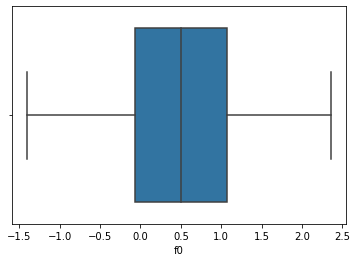


Гистограмма для столбца


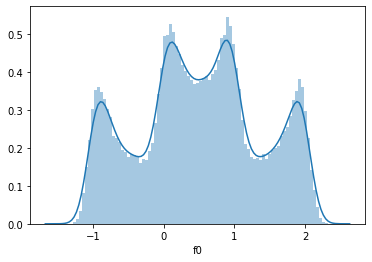

In [12]:
# применим функцию get_info_column() к geo_data_1, 'f0'
get_info_column(geo_data_1, 'f0')

___________________________________
Числовое описание данных столбца f1

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: -0.19

Диаграмма размаха столбца


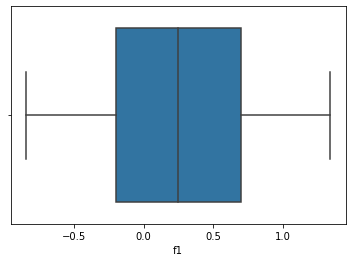


Гистограмма для столбца


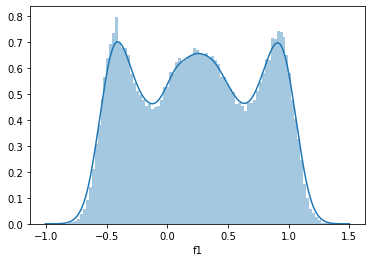

In [13]:
# применим функцию get_info_column() к geo_data_1, 'f1'
get_info_column(geo_data_1, 'f1')

___________________________________
Числовое описание данных столбца f2

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: 0.48

Диаграмма размаха столбца


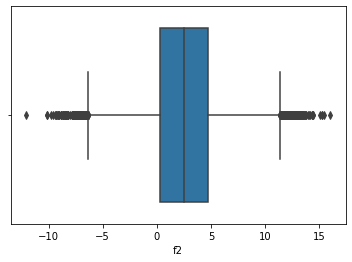


Гистограмма для столбца


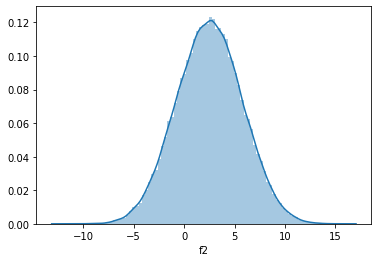

In [14]:
# применим функцию get_info_column() к geo_data_1, 'f2'
get_info_column(geo_data_1, 'f2')

________________________________________
Числовое описание данных столбца product

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: 1.00

Диаграмма размаха столбца


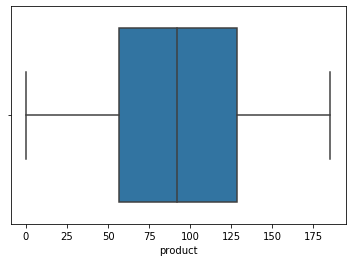


Гистограмма для столбца


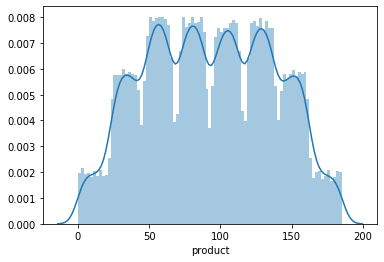

In [15]:
# применим функцию get_info_column() к geo_data_1, 'product'
get_info_column(geo_data_1, 'product')

___________________________________
Числовое описание данных столбца f0

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: -0.00

Диаграмма размаха столбца


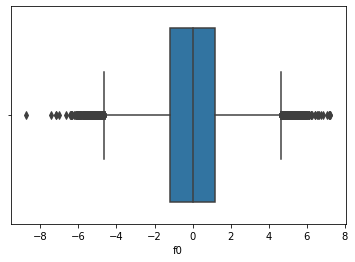


Гистограмма для столбца


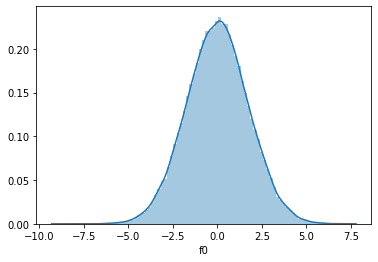

In [16]:
# применим функцию get_info_column() к geo_data_2, 'f0'
get_info_column(geo_data_2, 'f0')

___________________________________
Числовое описание данных столбца f1

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: -0.00

Диаграмма размаха столбца


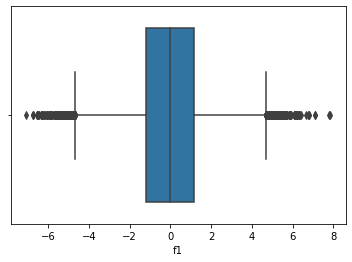


Гистограмма для столбца


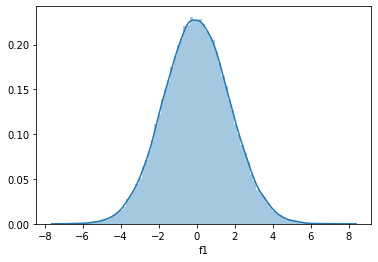

In [17]:
# применим функцию get_info_column() к geo_data_2, 'f1'
get_info_column(geo_data_2, 'f1')

___________________________________
Числовое описание данных столбца f2

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: 0.45

Диаграмма размаха столбца


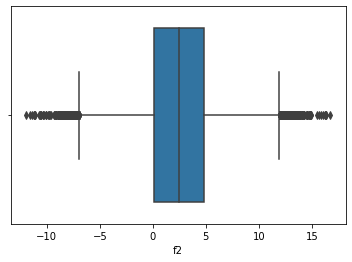


Гистограмма для столбца


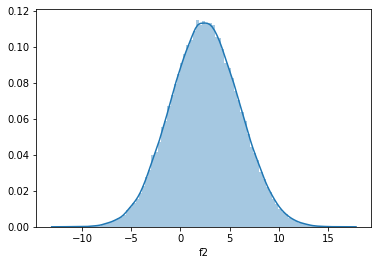

In [18]:
# применим функцию get_info_column() к geo_data_2, 'f2'
get_info_column(geo_data_2, 'f2')

________________________________________
Числовое описание данных столбца product

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

Коэффициент корреляции Пирсона с целевым признаком: 1.00

Диаграмма размаха столбца


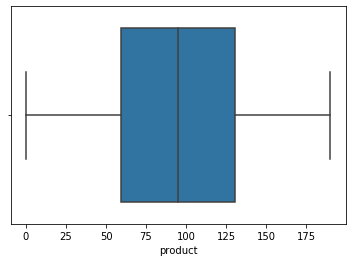


Гистограмма для столбца


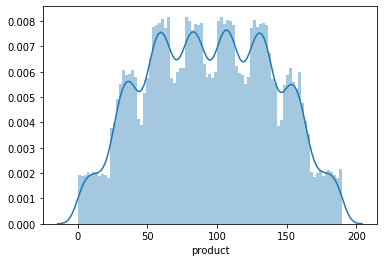

In [19]:
# применим функцию get_info_column() к geo_data_2, 'product'
get_info_column(geo_data_2, 'product')

### Вывод

Была получена общая информация о двух регионах. У датафреймов нет пропусков, корректный тип данных и распределение признаков выглядит нормальным. 

## II. Обучение и проверка модели

<a id='3-section'></a>
### 1. Подготовка к обучению моделей

В данной работе будут использованы следующие модели:
- линейная регрессия;
- решающее дерево;
- случайный лес.

In [20]:
# создадим объект структуры данных StandardScaler
scaler = StandardScaler()

In [21]:
# разделим данные по признакам и целевому признаку
def sampling_and_scaler(data):
    features = data.drop(["id", "product"], axis=1)
    target = data["product"]
    # сделаем тренировочную и тестовую выборку
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, train_size=0.75, random_state=12345
    )
    # необходимо масштабировать признаки
    # выберем признаки для стандартизации
    numeric = features_train.columns
    # сделаем копии выборок
    features_train = features_train.copy()
    features_test = features_test.copy()
    # настроим на обучающей выборке
    scaler.fit(features_train.loc[:, numeric])
    # преобразуем выборки
    features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
    features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])
    print(features_train.shape)
    print()
    print(features_test.shape)
    print()
    return features_train, features_test, target_train, target_test

In [22]:
# проверим размеры полученных выборок
(
    features_train_geo_1,
    features_test_geo_1,
    target_train_geo_1,
    target_test_geo_1,
) = sampling_and_scaler(geo_data_1)
(
    features_train_geo_2,
    features_test_geo_2,
    target_train_geo_2,
    target_test_geo_2,
) = sampling_and_scaler(geo_data_2)

(75000, 3)

(25000, 3)

(75000, 3)

(25000, 3)



Оценивать качество модели будем метрикой RMSE.

In [23]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [86]:
# напишем функцию для моделей с использованием GridSearchCV()
def gridsearchcv(model, parameters, x_train, x_test, y_train, y_test):
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring=mse)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(x_train, y_train)
    pred_test = best_model.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test) ** 0.5
    mae = mean_absolute_error(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    print('Cредний запас предсказанного сырья равен {:.2f} тыс. баррелей'.format(pred_test.mean()))
    print()
    print('Лучшее значение метрики RMSE: {:.2f}'.format(rmse))
    df = pd.DataFrame(data=[[rmse],[mae],[r2]], index=['rmse','mae','r2'], columns=['our_model'])
    return df, best_model, rmse, pred_test

<a id='4-section'></a>
### 2. Константные модели

In [25]:
# определим точность предсказания константной модели, всегда предсказывающей медиану
def dummy_model(x_train, x_test, y_train, y_test, strat):
    # константная модель, всегда предсказывающая значение по выбранной стратегии
    dummy = DummyRegressor(strategy=strat)
    dummy.fit(x_train, y_train)
    pred_test = dummy.predict(x_test)
    rmse = mean_squared_error(y_test, pred_test) ** 0.5
    print('Лучшее значение метрики RMSE для валидационной выборки: {:.2f}'.format(rmse))
    return round(rmse, 5)

In [26]:
dum_med_1 = dummy_model(
    features_train_geo_1, 
    features_test_geo_1, 
    target_train_geo_1, 
    target_test_geo_1, 
    'median'
)

Лучшее значение метрики RMSE для валидационной выборки: 44.29


In [27]:
dum_mean_1 = dummy_model(
    features_train_geo_1, 
    features_test_geo_1, 
    target_train_geo_1, 
    target_test_geo_1, 
    'mean'
)

Лучшее значение метрики RMSE для валидационной выборки: 44.29


In [28]:
dum_med_2 = dummy_model(
    features_train_geo_2, 
    features_test_geo_2, 
    target_train_geo_2, 
    target_test_geo_2, 
    'median'
)

Лучшее значение метрики RMSE для валидационной выборки: 44.90


In [29]:
dum_mean_2 = dummy_model(
    features_train_geo_2, 
    features_test_geo_2, 
    target_train_geo_2, 
    target_test_geo_2, 
    'mean'
)

Лучшее значение метрики RMSE для валидационной выборки: 44.90


Константная модель для первого региона получила значение метрики RMSE `44.29`, а для второго региона - `44.90`.

<a id='5-section'></a>
### 3. Линейная регрессия

In [30]:
%%time
# создадим словарь для линейной регрессии
param_lg = {}
df_lg_1, model_lg_1, rmse_lg_1, pred_lg_1 = gridsearchcv(
    LinearRegression(), 
    param_lg, 
    features_train_geo_1, 
    features_test_geo_1,
    target_train_geo_1,
    target_test_geo_1
)
df_lg_1

Cредний запас предсказанного сырья равен 92.59 тыс. баррелей

Лучшее значение метрики RMSE: 37.58
Wall time: 81 ms


,our_model
rmse,37.579422
mae,30.919601
r2,0.279943


In [31]:
%%time
# создадим словарь для линейной регрессии
param_lg = {}
df_lg_2, model_lg_2, rmse_lg_2, pred_lg_2 = gridsearchcv(
    LinearRegression(), 
    param_lg, 
    features_train_geo_2, 
    features_test_geo_2, 
    target_train_geo_2, 
    target_test_geo_2
)
df_lg_2

Cредний запас предсказанного сырья равен 94.97 тыс. баррелей

Лучшее значение метрики RMSE: 40.03
Wall time: 80.9 ms


,our_model
rmse,40.029709
mae,32.792652
r2,0.205248


<a id='6-section'></a>
### 4. Решающее дерево

In [32]:
%%time
# создадим словарь для решающего дерева
param_dt = {
    'max_depth'         : list(range(1, 102, 5)),
    'min_samples_split' : list(range(2, 6, 1)),
    'min_samples_leaf'  : list(range(2, 6, 1)),
    'random_state'      : [12345],
}
df_dt_1, model_dt_1, rmse_dt_1, pred_dt_1 = gridsearchcv(
    DecisionTreeRegressor(), 
    param_dt, 
    features_train_geo_1, 
    features_test_geo_1, 
    target_train_geo_1, 
    target_test_geo_1
)
df_dt_1

Cредний запас предсказанного сырья равен 92.59 тыс. баррелей

Лучшее значение метрики RMSE: 37.58
Wall time: 7min 47s


,our_model
rmse,37.575080
mae,30.879203
r2,0.280110


our_model
rmse	37.584269
mae	30.884590
r2	0.273034

In [33]:
%%time

df_dt_2, model_dt_2, rmse_dt_2, pred_dt_2 = gridsearchcv(
    DecisionTreeRegressor(), 
    param_dt, 
    features_train_geo_2, 
    features_test_geo_2, 
    target_train_geo_2, 
    target_test_geo_2
)
df_dt_2

Cредний запас предсказанного сырья равен 94.95 тыс. баррелей

Лучшее значение метрики RMSE: 38.27
Wall time: 8min 23s


,our_model
rmse,38.274275
mae,31.644586
r2,0.273424


rmse	38.096303
mae	31.498072
r2	0.270824

<a id='7-section'></a>
### 5. Случайный лес

In [34]:
%%time
# создадим словарь для решающего дерева
param_rf = {
    'n_estimators'      : list(range(1, 102, 10)),
    'max_depth'         : list(range(1, 32, 5)),
    'random_state'      : [12345],
}
df_rf_1, model_rf_1, rmse_rf_1, pred_rf_1 = gridsearchcv(
    RandomForestRegressor(), 
    param_rf, 
    features_train_geo_1, 
    features_test_geo_1, 
    target_train_geo_1, 
    target_test_geo_1
)
df_rf_1

Cредний запас предсказанного сырья равен 92.57 тыс. баррелей

Лучшее значение метрики RMSE: 37.14
Wall time: 53min 37s


,our_model
rmse,37.143203
mae,30.550546
r2,0.296563



our_model
rmse	37.190717
mae	30.585456
r2	0.288179

In [35]:
%%time
# создадим словарь для решающего дерева
df_rf_2, model_rf_2, rmse_rf_2, pred_rf_2 = gridsearchcv(
    RandomForestRegressor(), 
    param_rf, 
    features_train_geo_2, 
    features_test_geo_2, 
    target_train_geo_2, 
    target_test_geo_2
)
df_rf_2

Cредний запас предсказанного сырья равен 94.96 тыс. баррелей

Лучшее значение метрики RMSE: 37.70
Wall time: 1h 26min 13s


,our_model
rmse,37.701180
mae,31.118584
r2,0.295020


	our_model
rmse	37.452340
mae	30.958505
r2	0.295267

In [36]:
# функция для замены названия столбцов
def change_name_column(data, name):
    data.columns = [name]
change_name_column(df_lg_1, 'lin_reg_1')
change_name_column(df_lg_2, 'lin_reg_2')
change_name_column(df_dt_1, 'dec_tree_1')
change_name_column(df_dt_2, 'dec_tree_2')
change_name_column(df_rf_1, 'rand_for_1')
change_name_column(df_rf_2, 'rand_for_2')

In [37]:
first_region = round(pd.concat([df_lg_1, df_dt_1, df_rf_1], axis=1),2)
first_region

,lin_reg_1,dec_tree_1,rand_for_1
rmse,37.58,37.58,37.14
mae,30.92,30.88,30.55
r2,0.28,0.28,0.30


In [38]:
second_region = round(pd.concat([df_lg_2, df_dt_2, df_rf_2], axis=1),2)
second_region

,lin_reg_2,dec_tree_2,rand_for_2
rmse,40.03,38.27,37.70
mae,32.79,31.64,31.12
r2,0.21,0.27,0.30


Таким образом модель случайного леса показала себя лучше линейной регрессии и решающего дерева для обоих регионов.

<a id='8-section'></a>
### 6. Градиентный бустинг

Используем библиотеку LightGBM.

In [40]:
# создадим модель LGBMRegressor
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', 
                              objective='regression',
                              learning_rate=0.05,
                              feature_fraction=0.9,
                              random_state=12345,
                              silent=False
                             )

In [41]:
params_lgb={
    'num_leaves' : list(range(10,31,5)),
    'max_depth'  : list(range(10,31,5))
}

In [42]:
# получим значение RMSE для тестовой выборки для первого региона
df_lgb_1, model_lgb_1, rmse_lgb_1, pred_lgb_1 = gridsearchcv(
    model_lgb,
    params_lgb,
    features_train_geo_1,
    features_test_geo_1,
    target_train_geo_1,
    target_test_geo_1,
)
df_lgb_1

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.660937
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00154

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.652383
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00114

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.551162
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.635385
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00154

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.702472
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00222

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.660937
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00054

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.652383
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00193

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.702472
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_col_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.551162
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 92.660937
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00326

,our_model
rmse,37.011254
mae,30.488091
r2,0.301552


In [43]:
# получим значение RMSE для тестовой выборки для второго региона
df_lgb_2, model_lgb_2, rmse_lgb_2, pred_lgb_2 = gridsearchcv(
    model_lgb,
    params_lgb,
    features_train_geo_2,
    features_test_geo_2,
    target_train_geo_2,
    target_test_geo_2,
)
df_lgb_2

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 95.009021
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00075

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 95.130185
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 94.955963
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 94.912519
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 95.185257
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 95.009021
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 95.130185
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 94.955963
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_col_wise=true` to remove the overh

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 94.912519
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00054

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 3
[LightGBM] [Info] Start training from score 95.038589
Cредний запас предсказанного сырья равен 95.02 тыс. баррелей

Лучшее значение метрики RMSE: 37.60


,our_model
rmse,37.600066
mae,31.077951
r2,0.298796


Используем библиотеку XGBoost.

In [44]:
params_xgb={
    'max_depth'  : list(range(10,31,5))
}

In [45]:
# создадим модель XGBRegressor()
model_xgb = xgb.XGBRegressor(learning_rate=0.05,
                             max_depth=20,
                             random_state=12345)

In [46]:
# получим значение RMSE для тестовой выборки для первого региона
df_xgb_1, model_xgb_1, rmse_xgb_1, pred_xgb_1 = gridsearchcv(
    model_xgb,
    params_xgb,
    features_train_geo_1,
    features_test_geo_1,
    target_train_geo_1,
    target_test_geo_1,
)
df_xgb_1

Cредний запас предсказанного сырья равен 91.99 тыс. баррелей

Лучшее значение метрики RMSE: 37.24


,our_model
rmse,37.242929
mae,30.653879
r2,0.292781


In [47]:
# получим значение RMSE для тестовой выборки для второго региона
df_xgb_2, model_xgb_2, rmse_xgb_2, pred_xgb_2 = gridsearchcv(
    model_xgb,
    params_xgb,
    features_train_geo_2,
    features_test_geo_2,
    target_train_geo_2,
    target_test_geo_2,
)
df_xgb_2


Cредний запас предсказанного сырья равен 94.40 тыс. баррелей

Лучшее значение метрики RMSE: 37.80


,our_model
rmse,37.801762
mae,31.221835
r2,0.291253


Используем библиотеку CatBoost.

In [48]:
params_ctb={
    'depth'  : list(range(1,17,2))
}

In [49]:
# создадим модель CatBoostRegressor()
model_ctb = CatBoostRegressor(iterations=100,
                              learning_rate=0.05,
                              loss_function='RMSE',
                              verbose=33)

In [90]:
# получим значение RMSE для тестовой выборки для первого региона
df_ctb_1, model_ctb_1, rmse_ctb_1, pred_ctb_1 = gridsearchcv(
    model_ctb,
    params_ctb,
    features_train_geo_1,
    features_test_geo_1,
    target_train_geo_1,
    target_test_geo_1,
)
df_ctb_1

0:	learn: 43.9974345	total: 15ms	remaining: 1.48s
33:	learn: 39.5364759	total: 422ms	remaining: 819ms
66:	learn: 38.4341689	total: 826ms	remaining: 407ms
99:	learn: 37.9614153	total: 1.18s	remaining: 0us
0:	learn: 43.8856909	total: 7.77ms	remaining: 770ms
33:	learn: 39.5216795	total: 301ms	remaining: 584ms
66:	learn: 38.4176752	total: 636ms	remaining: 313ms
99:	learn: 37.9486969	total: 933ms	remaining: 0us
0:	learn: 43.8989899	total: 7.67ms	remaining: 759ms
33:	learn: 39.5345156	total: 274ms	remaining: 531ms
66:	learn: 38.4601573	total: 543ms	remaining: 267ms
99:	learn: 38.0041021	total: 806ms	remaining: 0us
0:	learn: 43.8822865	total: 5.3ms	remaining: 524ms
33:	learn: 39.4672544	total: 254ms	remaining: 492ms
66:	learn: 38.3913638	total: 479ms	remaining: 236ms
99:	learn: 37.9309448	total: 712ms	remaining: 0us
0:	learn: 43.9622108	total: 9.51ms	remaining: 941ms
33:	learn: 39.5306396	total: 229ms	remaining: 444ms
66:	learn: 38.4367579	total: 474ms	remaining: 234ms
99:	learn: 37.9713697	t

0:	learn: 43.6814439	total: 76.2ms	remaining: 7.54s
33:	learn: 37.4085417	total: 2.57s	remaining: 4.99s
66:	learn: 37.0419581	total: 5.06s	remaining: 2.49s
99:	learn: 36.9673388	total: 7.47s	remaining: 0us
0:	learn: 43.6814439	total: 81.5ms	remaining: 8.06s
33:	learn: 37.4085417	total: 2.72s	remaining: 5.29s
66:	learn: 37.0419581	total: 5.26s	remaining: 2.59s
99:	learn: 36.9673388	total: 7.71s	remaining: 0us
Cредний запас предсказанного сырья равен 92.56 тыс. баррелей

Лучшее значение метрики RMSE: 37.00


,our_model
rmse,36.996978
mae,30.478869
r2,0.302091


In [91]:
# получим значение RMSE для тестовой выборки для второго региона
df_ctb_2, model_ctb_2, rmse_ctb_2, pred_ctb_2 = gridsearchcv(
    model_ctb,
    params_ctb,
    features_train_geo_2,
    features_test_geo_2,
    target_train_geo_2,
    target_test_geo_2,
)
df_ctb_2

0:	learn: 44.4139511	total: 11.8ms	remaining: 1.17s
33:	learn: 40.8034614	total: 261ms	remaining: 508ms
66:	learn: 39.8291779	total: 533ms	remaining: 262ms
99:	learn: 39.2130809	total: 805ms	remaining: 0us
0:	learn: 44.3955846	total: 5.9ms	remaining: 584ms
33:	learn: 40.7866253	total: 277ms	remaining: 538ms
66:	learn: 39.8115080	total: 550ms	remaining: 271ms
99:	learn: 39.1964539	total: 829ms	remaining: 0us
0:	learn: 44.4197472	total: 6.82ms	remaining: 676ms
33:	learn: 40.7638369	total: 270ms	remaining: 525ms
66:	learn: 39.7808185	total: 547ms	remaining: 269ms
99:	learn: 39.1618085	total: 825ms	remaining: 0us
0:	learn: 44.3850898	total: 5.26ms	remaining: 521ms
33:	learn: 40.7540213	total: 258ms	remaining: 501ms
66:	learn: 39.7886731	total: 528ms	remaining: 260ms
99:	learn: 39.1734101	total: 782ms	remaining: 0us
0:	learn: 44.3665526	total: 5.2ms	remaining: 515ms
33:	learn: 40.7348901	total: 265ms	remaining: 515ms
66:	learn: 39.7553557	total: 527ms	remaining: 260ms
99:	learn: 39.1376279	

0:	learn: 44.0954960	total: 1s	remaining: 1m 39s
33:	learn: 37.7599920	total: 33.6s	remaining: 1m 5s
66:	learn: 37.2890583	total: 1m 6s	remaining: 32.6s
99:	learn: 37.1362341	total: 1m 40s	remaining: 0us
0:	learn: 44.0954960	total: 1.02s	remaining: 1m 40s
33:	learn: 37.7599920	total: 35.4s	remaining: 1m 8s
66:	learn: 37.2890583	total: 1m 8s	remaining: 33.7s
99:	learn: 37.1362341	total: 1m 42s	remaining: 0us
Cредний запас предсказанного сырья равен 94.99 тыс. баррелей

Лучшее значение метрики RMSE: 37.53


,our_model
rmse,37.533800
mae,31.024800
r2,0.301266


In [55]:
change_name_column(df_lgb_1, 'lightgbm_1')
change_name_column(df_lgb_2, 'lightgbm_2')
change_name_column(df_xgb_1, 'xgboost_1')
change_name_column(df_xgb_2, 'xgboost_2')
change_name_column(df_ctb_1, 'catboost_1')
change_name_column(df_ctb_2, 'catboost_2')

In [75]:
# добавим в таблицу first_region полученные значения
first_region = round(pd.concat([first_region, df_lgb_1, df_xgb_1, df_ctb_1], axis=1),2)
first_region

,lin_reg_1,dec_tree_1,rand_for_1,lightgbm_1,xgboost_1,catboost_1
rmse,37.58,37.58,37.14,37.01,37.24,37.00
mae,30.92,30.88,30.55,30.49,30.65,30.48
r2,0.28,0.28,0.30,0.30,0.29,0.30


In [76]:
# добавим в таблицу second_region полученные значения
second_region = round(pd.concat([second_region, df_lgb_2, df_xgb_2, df_ctb_2], axis=1),2)
second_region

,lin_reg_2,dec_tree_2,rand_for_2,lightgbm_2,xgboost_2,catboost_2
rmse,40.03,38.27,37.70,37.60,37.80,37.53
mae,32.79,31.64,31.12,31.08,31.22,31.02
r2,0.21,0.27,0.30,0.30,0.29,0.30


### Вывод

В результате данного этапа работы мы рассмотрели модели линейной регресии, решающего дерева, случайного леса и градиентного бустинга для каждого региона и смогли предсказать метрику RMSE. Данные были разбиты на тренировочную и тестовую выборки. Были получены значения среднего запаса предсказанного сырья и среднеквадратичное отклонение. Лучше всех себя показал CatBoost.

## III. Расчёт прибыли

<a id='9-section'></a>
### 1. Подготовка к расчёту прибыли

In [93]:
# введем новые переменные
# бюджет на разработку скважин в регионе
BUDGET = 10000000000 # рублей
# доход с единицы продукта
INCOME_PER_BARREL = 450000 # рублей за тысячу баррелей
# кол-во точек исследования
N = 500
# из них отбирают для расчета прибыли
BEST_N = 200

In [94]:
# расчитаем минимальный объем сырья, достаточный для безубыточной разработки новой скважины
min_barrel = round(BUDGET / (BEST_N * INCOME_PER_BARREL), 1)
min_barrel

111.1

Таким образом лучшие 200 точек из 500 отобранных должны содержать в себе в среднем минимум 111.1 тыс. баррелей запасов нефти, чтобы разработка новой скважины была безубыточной.

In [95]:
# создадим серию из полученных значений средних запасов на месторождении
# лучший результат показал CatBoost, поэтому возьмем его предикты
avg_product = pd.Series(
    data=[
        min_barrel,
        pred_ctb_1.mean(),
        pred_ctb_2.mean(),
    ],
    index=["min_barrel", "mean_1", "mean_2"],
)
avg_product

min_barrel    111.100000
mean_1         92.555489
mean_2         94.994527
dtype: float64

In [96]:
# создадим функцию, в которой считаем разность запаса нефти для безубыточной разработки и 
# реального запаса нефти месторождения в регионе
def get_diff(region):
    print(
        "Разница минимального запаса нефти на месторождении для безубыточной разработки скважины и среднего", end=' ')
    print("запаса нефти на месторождении региона {} равна {:.2f} тыс. баррелей".format(
            region, avg_product[0] - avg_product[region]
        )
    )

In [98]:
get_diff(1)
print()
get_diff(2)

Разница минимального запаса нефти на месторождении для безубыточной разработки скважины и среднего запаса нефти на месторождении региона 1 равна 18.54 тыс. баррелей

Разница минимального запаса нефти на месторождении для безубыточной разработки скважины и среднего запаса нефти на месторождении региона 2 равна 16.11 тыс. баррелей


<a id='10-section'></a>
### 2. Расчёт прибыли

In [127]:
pred_ctb_1 = pd.Series(pred_ctb_1,index=target_test_geo_1.index)
pred_ctb_2 = pd.Series(pred_ctb_2,index=target_test_geo_2.index)

In [154]:
# создадим функцию для расчёта максимальной прибыли для региона
def profit_calculation(region, pred_test, target_test):
    # выберем скважины с максимальными значениями предсказаний (топ-200)
    best_200 = pred_test.sort_values(ascending=False)[:BEST_N]
    target_200 = target_test[best_200.index][:BEST_N]
    # тогда доход по этим месторождениям равен
    income = INCOME_PER_BARREL * target_200.sum()
    # прибыль равна
    profit = income - BUDGET
    return round(profit/1000000000, 3) # млрд.рублей

In [155]:
# применим функцию profit_calculation() к pred_ctb_1
profit_calculation(1, pred_ctb_1, target_test_geo_1)

3.312

In [156]:
# применим функцию profit_calculation() к pred_ctb_2
profit_calculation(2, pred_ctb_2, target_test_geo_2)

3.681

### Вывод

В процессе разработки новой скважины в регионе выбираются 500 месторождений из возможных 100000 и из них отбираются 200 с наибольшим запасом сырья.

В конечном итоге было получено значение минимального запаса нефти на месторождении, чтобы данная разработка была хотя бы безубыточной. Оно ровняется 111.1 тыс. баррелей и для первого и второго регионов на 18.54 и  16.11 тыс. баррелей соответственно больше среднего значения запаса сырья на месторождении для данных регионов.

После того, как была расчитана максимальная прибыль топ-200 месторождений, можно сказать, что регионы могут принести максимально до 3.312 и 3.681 млрд. рублей прибыли соответственно.

## IV. Распределение прибыли и риски

<a id='11-section'></a>
### 1.  Bootstrap

In [165]:
# применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
def bootstrap(region, target, predicted, k):
    state = np.random.RandomState(12345)
    values = []
    for i in range(k):
        target_subsample = target.sample(n=500, replace=True, random_state = state)
        predicted_subsample = predicted[target_subsample.index]
    
        values.append(profit_calculation(region, predicted_subsample, target_subsample))
 
    values = pd.Series(values) * 1000
 
    mean = values.mean()
    print("Средняя прибыль региона {} составляет: {:.2f} млн. рублей".format(region, mean))
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print()
    # расчет риска убытков
    print('Риск убытков для региона {} равен {:.1%}'.format(region, (values < 0).sum() / len(values)))
    print()
    print('Для 95%-ого интервала прибыль для региона {} составит от {:.2f} до {:.2f} млн. рублей'.format(region, lower , upper))
    values.plot(kind='hist', title='Распределение потенциальной прибыли', figsize=(9,6))
    plt.show()
    return values # млн. рублей

Средняя прибыль региона 1 составляет: 525.02 млн. рублей

Риск убытков для региона 1 равен 3.3%

Для 95%-ого интервала прибыль для региона 1 составит от -19.00 до 1013.00 млн. рублей


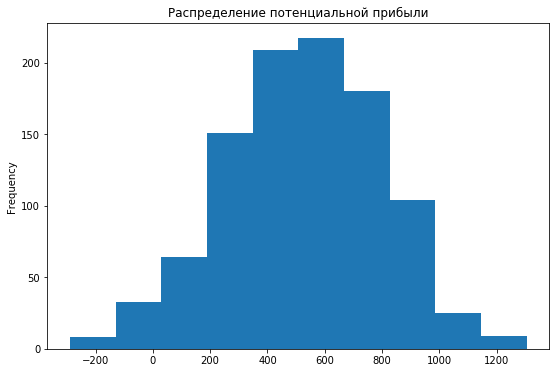

In [166]:
values_1 = bootstrap(1, target_test_geo_1, pred_ctb_1, 1000)

Средняя прибыль региона 2 составляет: 744.52 млн. рублей

Риск убытков для региона 2 равен 0.3%

Для 95%-ого интервала прибыль для региона 2 составит от 209.00 до 1282.00 млн. рублей


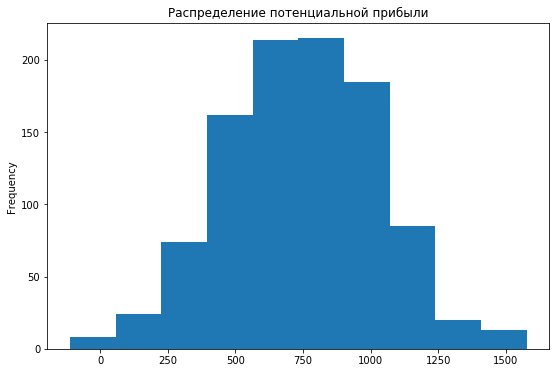

In [160]:
values_2 = bootstrap(2, target_test_geo_2, pred_ctb_2, 1000)

### Вывод

На основании полученных результатов регион 2 рекомендуется для разработки новых скважин. 

Средняя прибыль региона 2 составит 744.52 млн. рублей и риск убытков равен 0.3 %.

Также с вероятностью в 95% во втором регионе мы получим от 209 до 1282 млн. рублей прибыли.

<a id='12-section'></a>
## V. Общий вывод

**На основании полученных результатов регион 2 рекомендуется для разработки новых скважин.**

В данной работе была получена модель машинного обучения, которая помогла нам определить регион, где добыча нефти принесла бы нашей компании наибольшую прибыль.

Проект был разбит на несколько частей.

Изначально была получена общая информация о предоставленных двух датафреймах: данные были чистыми.

и смогли предсказать метрику RMSE. Данные были разбиты на тренировочную и тестовую выборки. Были получены значения среднего запаса предсказанного сырья и среднеквадратичное отклонение. Лучше всех себя показал `CatBoost`.

Затем мы обучили модели линейной регресии, решающего дерева, случайного леса и градиентного бустинга для каждого региона и смогли предсказать запас сырья для каждого месторождения. Были получены значения среднего запаса предсказанного сырья и среднеквадратичное отклонение. Лучший результат был получен с помощью CatBoost. Значение `RMSE = 37.00` тыс. баррелей у 1-го региона.

Далее мы приступили к расчёту прибыли. В процессе разработки новой скважины в регионе выбираются 500 месторождений из возможных 100000 и из них отбираются 200 с наибольшим запасом сырья. В конечном итоге было получено значение минимального запаса нефти на месторождении, чтобы данная разработка была хотя бы безубыточной. Оно ровняется `111.1` тыс. баррелей и для первого и второго регионов на `18.54` и `16.11` тыс. баррелей соответственно больше среднего значения запаса сырья на месторождении для данных регионов.

С помощью техники bootstrap было получено распределение прибыли. Были посчитаны средние значения прибыли и доверительный интервал в 95%, построены гистограммы распределения прибыли, расчитаны риски.

В результате чего для первого региона:
 - средняя прибыль равна `525.02` млн. рублей;
 - риск убытков равен `3.3%`;
 - для 95%-ого интервала прибыль составит от `-19` до `1013` млн. рублей.

В результате чего для второго региона:
 - средняя прибыль равна `744.52` млн. рублей;
 - риск убытков равен `0.3%`;
 - для 95%-ого интервала прибыль составит от `209` до `1282` млн. рублей.